In [1]:
import PIL, torch, torchvision
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

from torchvision import models
from torch import nn

if torch.cuda.is_available() == True:
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")

print(device)
dtype = torch.float32

OCC_ONLY = Path('/home/florian/MT-Roxi/Occ_only_226px/')
IMGS = Path('/home/florian/MT-Roxi/scaled images/')
OCC = Path('/home/florian/MT-Roxi/tobii_export/')

cuda:0


# Extract Labels

In [2]:
labels = []
for i,f in enumerate(list(sorted(IMGS.iterdir()))):
    labels.append(int(f.name[-6]))
labels = torch.Tensor(labels).to(device)

In [3]:
classses = {
    0:'fish',
    1:'dog',
    2:'cassette player',
    3:'chainsaw',
    4:'church',
    5:'music instrument',
    6:'garbage truck',
    7:'gas',
    8:'golfball',
    9:'parachute',
}

### Load Image and Heat Map with PIL

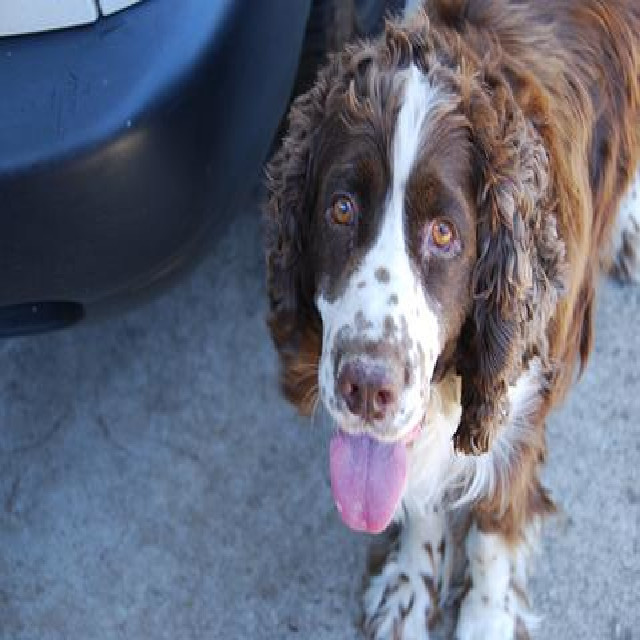

In [4]:
ex_img = list(sorted(IMGS.iterdir()))[0]
ex_img = PIL.Image.open(ex_img);ex_img # Eye-Tracking Map

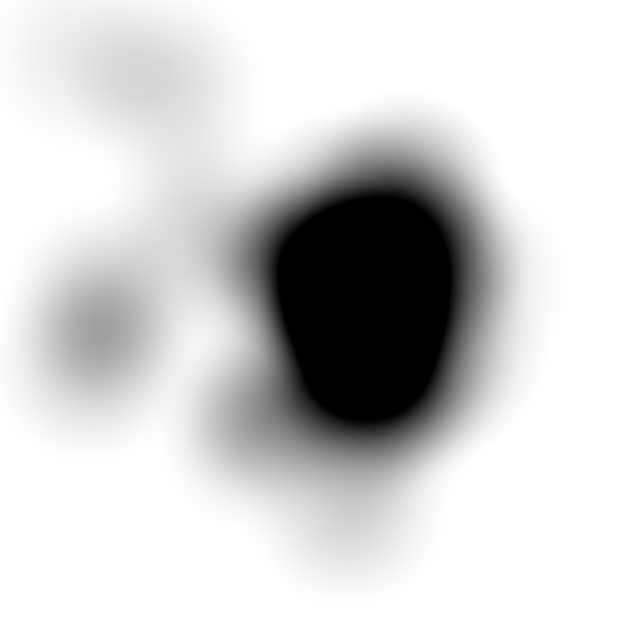

In [5]:
ex_map = list(sorted(OCC_ONLY.iterdir()))[0]
ex_map = PIL.Image.open(ex_map);ex_map # Eye-Tracking Map
#This is what we get from Tobii

### Resize and Normalize Heat Map

In [6]:
def process_maps(etm):
    etm = etm.resize((224,224))
    x = np.asarray(etm)
    x = np.transpose(x, (2,0,1))[3]/255
    return np.expand_dims(x, axis=0)

etm = process_maps(ex_map)

#test if map is in valid range of 0 and 1
assert etm.max() <= 1
assert etm.min() >= 0
#test if map has one channel and target size of 224
assert etm.shape ==(1,224,224)

def process_imgs(img):
    img = img.resize((224,224))
    x = np.asarray(img)
    if len(x.shape) != 3:
        x = np.expand_dims(x,2)
        x = np.concatenate((x,x,x),2)
    x = np.transpose(x, (2,0,1))/255
    return x

#test if processing works for 3 channel images
img = process_imgs(ex_img)
#test if image is in valid range of 0 and 1
assert img.max() <= 1
assert img.min() >= 0
#test if final image has 3 channels and target size of 224
assert img.shape ==(3,224,224)

#test if processing works for 1 channel b/w images (that occur in the imagenette dataset)
test_bw_img = PIL.Image.fromarray(np.uint8(np.random.rand(224,224)*255))
img = process_imgs(test_bw_img)
#test if image is in valid range of 0 and 1
assert img.max() <= 1
assert img.min() >= 0
#test if final image has 3 channels and target size of 224
assert img.shape ==(3,224,224)

## Construct Image and Heatmap Batches

In [7]:
img_batch = torch.empty((0,3,224,224))
etm_batch = torch.empty((0,1,224,224))

In [8]:
for img, mask in zip(sorted(IMGS.iterdir()), sorted(OCC_ONLY.iterdir())):
    img = PIL.Image.open(img)
    img = process_imgs(img)
    
    etm = process_maps(PIL.Image.open(mask))
    etm_batch = torch.cat((etm_batch,torch.Tensor(etm).unsqueeze(0)))
    img_batch = torch.cat((img_batch,torch.Tensor(img).unsqueeze(0)))

In [9]:
img_batch = img_batch.to(device)
etm_batch = etm_batch.to(device)

In [10]:
assert img_batch.shape[1:] == (3,224,224) #check that img batch has format (NCHW)

## Load Model

In [11]:
#utils
def batch_accuracy(x,y): return round(((model(x).argmax(1)==y).sum()/x.shape[0]).item(), 4)

class ImageNetNormalization(nn.Module):
    def __init__(self, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)):
        super(ImageNetNormalization, self).__init__()
        self.mean = torch.tensor(mean)
        self.std = torch.tensor(std)

    def forward(self, x):
        return torchvision.transforms.functional.normalize(x, self.mean, self.std)

###### Resnet

In [12]:
base_resnet = models.resnet18(pretrained=True)

num_ftrs_in = base_resnet.fc.in_features
num_ftrs_out = 10
base_resnet.fc = nn.Linear(num_ftrs_in, num_ftrs_out)
resnet = torch.nn.Sequential(
    ImageNetNormalization(),
    base_resnet
)

MODEL_PATH = './models/ResNet18.pt'
state_dict = torch.load(MODEL_PATH)
resnet.load_state_dict(state_dict)
resnet = resnet.to(device)
model = resnet
batch_accuracy(img_batch, labels)

1.0

###### MobileNet V3 Small

In [13]:
base_mobilenet = models.mobilenet_v3_small(pretrained=True)

num_ftrs_in = base_mobilenet.classifier[0].in_features
num_ftrs_out = base_mobilenet.classifier[0].out_features
base_mobilenet.classifier[0] = nn.Linear(num_ftrs_in, num_ftrs_out)

num_ftrs_in = base_mobilenet.classifier[3].in_features
num_ftrs_out = 10
base_mobilenet.classifier[3] = nn.Linear(num_ftrs_in, num_ftrs_out)

mobilenet = torch.nn.Sequential(
    ImageNetNormalization(),
    base_mobilenet
)

MODEL_PATH = './models/MobileNetV3Small.pt'
state_dict = torch.load(MODEL_PATH)
mobilenet.load_state_dict(state_dict)
mobilenet = mobilenet.to(device)
model = mobilenet
batch_accuracy(img_batch, labels)


1.0

## Attacks

In [14]:
def FGSM(model, inputs, eps=8/255, use_eye_tracking_maps = True):
    model.eval()
    criterion = nn.CrossEntropyLoss()
    inputs.to(device)
    inputs.requires_grad = True
    preds = model(inputs)
    loss = criterion(preds, labels.long())
    loss.backward(retain_graph=True)
    grads = inputs.grad
    
    if use_eye_tracking_maps==False:
        perturbation = torch.sign(grads).clamp_(-eps,eps)
        adv_examples = img_batch + perturbation
        adv_examples.clamp_(0,1).detach_()

    if use_eye_tracking_maps==True:
        perturbation = torch.sign(grads).clamp_(-eps,eps)
        perturbation = .5*perturbation + .5*perturbation*(1-etm_batch)
        adv_examples = img_batch + perturbation
        adv_examples.clamp_(0,1).detach_()
    return adv_examples, perturbation
model = mobilenet

#Tests
accs = []
for i, eps in enumerate([.0,.01,.02,.03]):
    adv_examples, perturbation = FGSM(model, img_batch, eps=eps, use_eye_tracking_maps=False)
    assert perturbation.abs().max() <= eps
    assert adv_examples.min() >= 0
    assert adv_examples.max() <= 1
    accs.append(batch_accuracy(adv_examples, labels))
    if i>0:
        assert accs[-1]<=accs[-2] #
    
for eps in [.1,.2,.3]:
    hpa_adv_examples, hpa_perturbation = FGSM(model, img_batch, eps=eps, use_eye_tracking_maps=True)
    assert hpa_perturbation.abs().max() <= eps
    assert hpa_adv_examples.min() >= 0
    assert hpa_adv_examples.max() <= 1

In [15]:
def FGSM_step(model, inputs, criterion, eps):
    preds = model(inputs)
    loss = criterion(preds, labels.long())
    loss.backward(retain_graph=True)
    grads = inputs.grad
    perturbation = torch.sign(grads).clamp_(-eps,eps)
    return perturbation

def PGD(model, inputs, steps, eps, stepsize=None, use_eye_tracking_maps = True, random_start=False):
    if stepsize == None: stepsize = eps/steps * 5
    model.eval()
    criterion = nn.CrossEntropyLoss()
    if random_start == False: perturbation = torch.zeros_like(inputs)
    if random_start == True: perturbation = torch.randn_like(inputs) * (1-etm_batch)
    adv_examples = inputs+perturbation
    inputs.requires_grad = True
    adv_examples.retain_grad()
    for step in range(steps):
        pert_step = FGSM_step(model, adv_examples, criterion, stepsize)
        perturbation += pert_step
        if use_eye_tracking_maps == True: 
            perturbation = perturbation.clamp(-eps,eps)
            perturbation = 0.5*perturbation + 0.5* perturbation * (1-etm_batch)
            assert (perturbation<(1-.5*etm_batch)).all()
            #perturbation = perturbation.clamp(min=-(etm_batch*0.5*eps+0.5*eps), max=(etm_batch*0.5*eps)+0.5*eps)
        else: perturbation = perturbation.clamp(-eps,eps)
        adv_examples = inputs + perturbation
        adv_examples.retain_grad()
    perturbation = perturbation.clamp(-eps,eps)
    perturbation.abs().max()
    adv_examples = (inputs+perturbation).clamp(0,1)
    return perturbation, adv_examples

perturbation, adv_examples = PGD(model, img_batch, 5, 8/255, use_eye_tracking_maps=False, random_start=True)
perturbation, adv_examples = PGD(model, img_batch, 5, 8/255, use_eye_tracking_maps=True, random_start=True)



# Tests

In [16]:
STEPS = 10
ifgsm_acc_5 = []
ifgsm_hpa_acc_5 = []
pgd_acc_5 = []
pgd_hpa_acc_5 = []
epsilons = (torch.Tensor([0,1,2,4,8,16]))/255
for i, eps in enumerate(epsilons):
    ifgsm_perturbation, ifgsm_adv_examples = PGD(model, img_batch,STEPS, eps=eps, random_start=False, use_eye_tracking_maps=False)
    ifgsm_hpa_perturbation, ifgsm_hpa_adv_examples = PGD(model, img_batch,STEPS, eps=eps, random_start=False, use_eye_tracking_maps=True)
    pgd_perturbation, pgd_adv_examples = PGD(model, img_batch,STEPS , eps=eps, random_start=True, use_eye_tracking_maps=False)
    pgd_hpa_perturbation, pgd_hpa_adv_examples = PGD(model, img_batch,STEPS , eps=eps, random_start=True, use_eye_tracking_maps=True)
    ifgsm_acc_5.append(batch_accuracy(ifgsm_adv_examples, labels))
    ifgsm_hpa_acc_5.append(batch_accuracy(ifgsm_hpa_adv_examples, labels))
    pgd_acc_5.append(batch_accuracy(pgd_adv_examples, labels))
    pgd_hpa_acc_5.append(batch_accuracy(pgd_hpa_adv_examples, labels))
    clean_acc = batch_accuracy(img_batch, labels)
    print('Epsilon:', str(int(eps.item()*255))+'/255',
          ' - IFGSM accuracy:', ifgsm_acc_5[-1],
          ' - HPA-IFGSM accuracy:', ifgsm_hpa_acc_5[-1],
          ' - PGD accuracy:', pgd_acc_5[-1],
          ' - HPA-PGD accuracy:', pgd_hpa_acc_5[-1],
          ' - clean accuracy:', clean_acc,
    )
    assert ifgsm_acc_5[-1]<=ifgsm_hpa_acc_5[-1] #test that hpa restricted attack is less effective
    assert pgd_acc_5[-1]<=pgd_hpa_acc_5[-1] #test that hpa restricted attack is less effective
    
    if i>0:
        print(ifgsm_hpa_acc_5[-1], ifgsm_hpa_acc_5[-2])
        assert ifgsm_acc_5[-1]<=ifgsm_acc_5[-2] #
        assert ifgsm_hpa_acc_5[-1]<=ifgsm_hpa_acc_5[-2]
        assert pgd_acc_5[-1]<=pgd_hpa_acc_5[-2]
        assert pgd_hpa_acc_5[-1]<=pgd_hpa_acc_5[-2]

STEPS = 30
ifgsm_acc_50 = []
ifgsm_hpa_acc_50 = []
pgd_acc_50 = []
pgd_hpa_acc_50 = []
epsilons = (torch.Tensor([0,1,2,4,8,16]))/255
for i, eps in enumerate(epsilons):
    ifgsm_perturbation, ifgsm_adv_examples = PGD(model, img_batch, STEPS, eps=eps, random_start=False, use_eye_tracking_maps=False)
    ifgsm_hpa_perturbation, ifgsm_hpa_adv_examples = PGD(model, img_batch,STEPS, eps=eps, random_start=False, use_eye_tracking_maps=True)
    pgd_perturbation, pgd_adv_examples = PGD(model, img_batch,STEPS , eps=eps, random_start=True, use_eye_tracking_maps=False)
    pgd_hpa_perturbation, pgd_hpa_adv_examples = PGD(model, img_batch,STEPS , eps=eps, random_start=True, use_eye_tracking_maps=True)
    ifgsm_acc_50.append(batch_accuracy(ifgsm_adv_examples, labels))
    ifgsm_hpa_acc_50.append(batch_accuracy(ifgsm_hpa_adv_examples, labels))
    pgd_acc_50.append(batch_accuracy(pgd_adv_examples, labels))
    pgd_hpa_acc_50.append(batch_accuracy(pgd_hpa_adv_examples, labels))
    clean_acc = batch_accuracy(img_batch, labels)
    print('Epsilon:', str(int(eps.item()*255))+'/255',
          ' - IFGSM accuracy:', ifgsm_acc_50[-1],
          ' - HPA-IFGSM accuracy:', ifgsm_hpa_acc_50[-1],
          ' - PGD accuracy:', pgd_acc_50[-1],
          ' - HPA-PGD accuracy:', pgd_hpa_acc_50[-1],
          ' - clean accuracy:', clean_acc,
    )
    assert ifgsm_acc_50[-1]<=ifgsm_hpa_acc_50[-1] #test that hpa restricted attack is less effective
    assert pgd_acc_50[-1]<=pgd_hpa_acc_50[-1] #test that hpa restricted attack is less effective
    if i>0:
        assert ifgsm_acc_50[-1]<=ifgsm_acc_50[-2] #test that higher eps increases attack effectivness
        assert ifgsm_hpa_acc_50[-1]<=ifgsm_hpa_acc_50[-2] #test that higher eps increases attack effectivness
        assert pgd_acc_50[-1]<=pgd_hpa_acc_50[-2] #test that higher eps increases attack effectivness
        assert pgd_hpa_acc_50[-1]<=pgd_hpa_acc_50[-2] #test that higher eps increases attack effectivness

for i in range(len(ifgsm_acc_50)): # Test that the 50 step attack is more effective than the 5 step attack
    print(i)
    print(ifgsm_hpa_acc_50[i],ifgsm_hpa_acc_5[i])
    assert ifgsm_acc_50[i]<=ifgsm_acc_5[i]
    assert ifgsm_hpa_acc_50[i]<=ifgsm_hpa_acc_5[i]
    assert pgd_acc_50[i]<=pgd_acc_5[i]
    assert pgd_hpa_acc_50[i]<=pgd_hpa_acc_5[i]

Epsilon: 0/255  - IFGSM accuracy: 1.0  - HPA-IFGSM accuracy: 1.0  - PGD accuracy: 1.0  - HPA-PGD accuracy: 1.0  - clean accuracy: 1.0
Epsilon: 1/255  - IFGSM accuracy: 0.04  - HPA-IFGSM accuracy: 0.08  - PGD accuracy: 0.05  - HPA-PGD accuracy: 0.08  - clean accuracy: 1.0
0.08 1.0
Epsilon: 2/255  - IFGSM accuracy: 0.0  - HPA-IFGSM accuracy: 0.01  - PGD accuracy: 0.01  - HPA-PGD accuracy: 0.01  - clean accuracy: 1.0
0.01 0.08
Epsilon: 4/255  - IFGSM accuracy: 0.0  - HPA-IFGSM accuracy: 0.0  - PGD accuracy: 0.0  - HPA-PGD accuracy: 0.0  - clean accuracy: 1.0
0.0 0.01
Epsilon: 8/255  - IFGSM accuracy: 0.0  - HPA-IFGSM accuracy: 0.0  - PGD accuracy: 0.0  - HPA-PGD accuracy: 0.0  - clean accuracy: 1.0
0.0 0.0
Epsilon: 16/255  - IFGSM accuracy: 0.0  - HPA-IFGSM accuracy: 0.0  - PGD accuracy: 0.0  - HPA-PGD accuracy: 0.0  - clean accuracy: 1.0
0.0 0.0
Epsilon: 0/255  - IFGSM accuracy: 1.0  - HPA-IFGSM accuracy: 1.0  - PGD accuracy: 1.0  - HPA-PGD accuracy: 1.0  - clean accuracy: 1.0
Epsilon: 1

# Visualize

In [17]:
eps = 4/255
STEPS = 10
ifgsm_perturbation, ifgsm_adv_examples = PGD(model, img_batch, STEPS, eps=eps, random_start=False, use_eye_tracking_maps=False)
ifgsm_hpa_perturbation, ifgsm_hpa_adv_examples = PGD(model, img_batch,STEPS, eps=eps, random_start=False, use_eye_tracking_maps=True)
pgd_perturbation, pgd_adv_examples = PGD(model, img_batch,STEPS , eps=eps, random_start=True, use_eye_tracking_maps=False)
pgd_hpa_perturbation, pgd_hpa_adv_examples = PGD(model, img_batch,STEPS , eps=eps, random_start=True, use_eye_tracking_maps=True)

print(
    batch_accuracy(ifgsm_adv_examples, labels),
    batch_accuracy(ifgsm_hpa_adv_examples, labels),
    batch_accuracy(pgd_adv_examples, labels),
    batch_accuracy(pgd_hpa_adv_examples, labels)
)

0.0 0.0 0.0 0.0


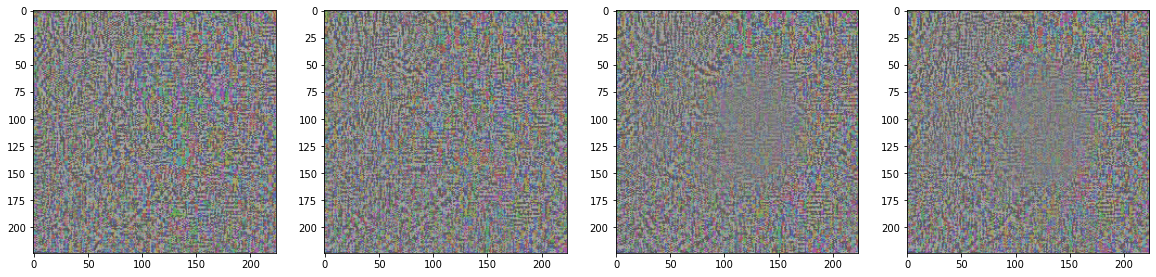

In [18]:
fig, axes = plt.subplots(1,4, figsize=(20,10))
axes = axes.flatten()
axes[0].imshow(ifgsm_perturbation[0].detach().cpu().permute(1,2,0)*10+.5)
axes[1].imshow(pgd_perturbation[0].detach().cpu().permute(1,2,0)*10+.5)
axes[2].imshow(ifgsm_hpa_perturbation[0].detach().cpu().permute(1,2,0)*10+.5)
axes[3].imshow(pgd_hpa_perturbation[0].detach().cpu().permute(1,2,0)*10+.5)

In [19]:
print(
    ifgsm_perturbation[0].abs().mean(),
    ifgsm_perturbation[0].abs().max(),
    ifgsm_perturbation[0].abs().min()
)

print(
    pgd_perturbation[0].abs().mean(),
    pgd_perturbation[0].abs().max(),
    pgd_perturbation[0].abs().min()
)

print(
    ifgsm_hpa_perturbation[0].abs().mean(),
    ifgsm_hpa_perturbation[0].abs().max(),
    ifgsm_hpa_perturbation[0].abs().min()
)

print(
    pgd_hpa_perturbation[0].abs().mean(),
    pgd_hpa_perturbation[0].abs().max(),
    pgd_hpa_perturbation[0].abs().min()
)

tensor(0.0107, device='cuda:0') tensor(0.0157, device='cuda:0') tensor(0., device='cuda:0')
tensor(0.0107, device='cuda:0') tensor(0.0157, device='cuda:0') tensor(0., device='cuda:0')
tensor(0.0093, device='cuda:0') tensor(0.0157, device='cuda:0') tensor(0., device='cuda:0')
tensor(0.0094, device='cuda:0') tensor(0.0157, device='cuda:0') tensor(0., device='cuda:0')


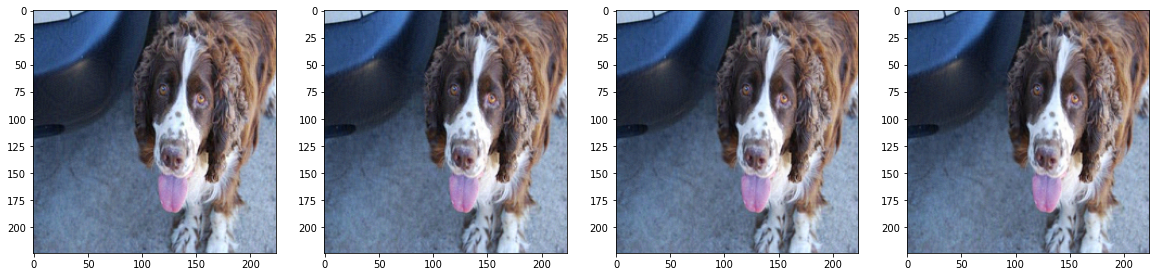

In [20]:
fig, axes = plt.subplots(1,4, figsize=(20,10))
axes = axes.flatten()
axes[0].imshow(ifgsm_adv_examples[0].detach().cpu().permute(1,2,0))
axes[1].imshow(pgd_adv_examples[0].detach().cpu().permute(1,2,0))
axes[2].imshow(ifgsm_hpa_adv_examples[0].detach().cpu().permute(1,2,0))
axes[3].imshow(pgd_hpa_adv_examples[0].detach().cpu().permute(1,2,0))

In [21]:
def viz(inp):
    plt.imshow((inp).detach().cpu().permute(1,2,0))
def viz_etm(inp):
    plt.imshow(inp.detach().cpu().permute(1,2,0))
def viz_pert(inp):
    plt.imshow((inp+0.5).detach().cpu().permute(1,2,0))

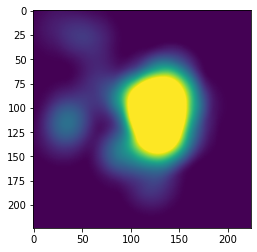

In [22]:
viz_etm(etm_batch[0])

tensor(-0.0314, device='cuda:0')


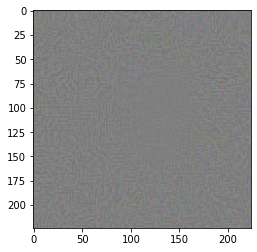

In [23]:
print(perturbation.min())
viz_pert(perturbation[0])

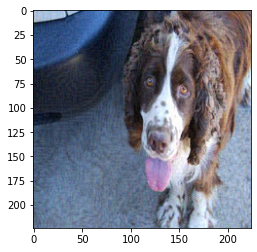

In [24]:
viz(adv_examples[0])

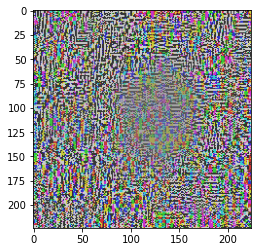

In [25]:
viz_pert(hpa_perturbation[0])

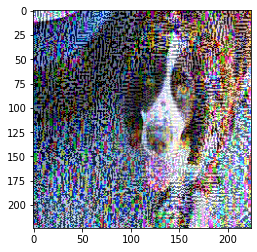

In [26]:
viz(hpa_adv_examples[0])

In [46]:
import foolbox
from foolbox.attacks import PGD, FGSM

In [47]:
attack = FGSM()

In [48]:
img_batch.requires_grad_(False)
model.eval()
fmodel = foolbox.PyTorchModel(
    model.to(device), 
    bounds=(0,1), 
    #preprocessing=dict(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], axis=-3)
)
raw_advs, clipped_advs, success = attack(
    fmodel, 
    img_batch.to(device), 
    criterion=labels.long().to(device), 
    epsilons=[8/255]
)

In [49]:
clipped_advs

[tensor([[[[0.6863, 0.6941, 0.6353,  ..., 0.4745, 0.5255, 0.5294],
           [0.6235, 0.6314, 0.6353,  ..., 0.4706, 0.5451, 0.5373],
           [0.6235, 0.6314, 0.6353,  ..., 0.4980, 0.5216, 0.5216],
           ...,
           [0.3451, 0.3843, 0.4157,  ..., 0.5098, 0.5294, 0.5176],
           [0.3529, 0.3882, 0.4314,  ..., 0.5451, 0.5098, 0.5020],
           [0.3686, 0.3882, 0.4196,  ..., 0.4980, 0.5373, 0.5059]],
 
          [[0.7647, 0.7725, 0.7137,  ..., 0.3765, 0.4235, 0.3647],
           [0.7020, 0.7098, 0.7137,  ..., 0.3804, 0.4471, 0.4353],
           [0.7020, 0.7098, 0.7137,  ..., 0.3490, 0.4314, 0.4235],
           ...,
           [0.4196, 0.4627, 0.4941,  ..., 0.5765, 0.6588, 0.6471],
           [0.4431, 0.4784, 0.5255,  ..., 0.6118, 0.6392, 0.6314],
           [0.4706, 0.4902, 0.5216,  ..., 0.5647, 0.6039, 0.5725]],
 
          [[0.8706, 0.8784, 0.8196,  ..., 0.3922, 0.3765, 0.3765],
           [0.8078, 0.8157, 0.8196,  ..., 0.4000, 0.4039, 0.3882],
           [0.8078, 0.81